# DATASET USED: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
**License
CC BY-NC-SA 4.0**

**Code author: Andrei Ciprian Alexandru**

**URN: 6592956**

**Notebook created: 04/04/2023**

**Last update: 16/05/2023**

# ***Import the necessary libraries, load the data and create the data loaders***

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import graphviz
import random
from graphviz import Digraph
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms

# Load and preprocess the cancer data
data = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)
data['diagnosis'] = data['diagnosis'].map({'M': 0, 'B': 1})

# Prepare the data
features = data.drop('diagnosis', axis=1).values
labels = data['diagnosis'].values

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into train and test sets
train_features, test_features, train_labels, test_labels = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

batch_size = 64

# Create data loaders
train_dataset = TensorDataset(torch.tensor(train_features, dtype=torch.float32), torch.tensor(train_labels, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(test_features, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ***Plot dataset analytics***

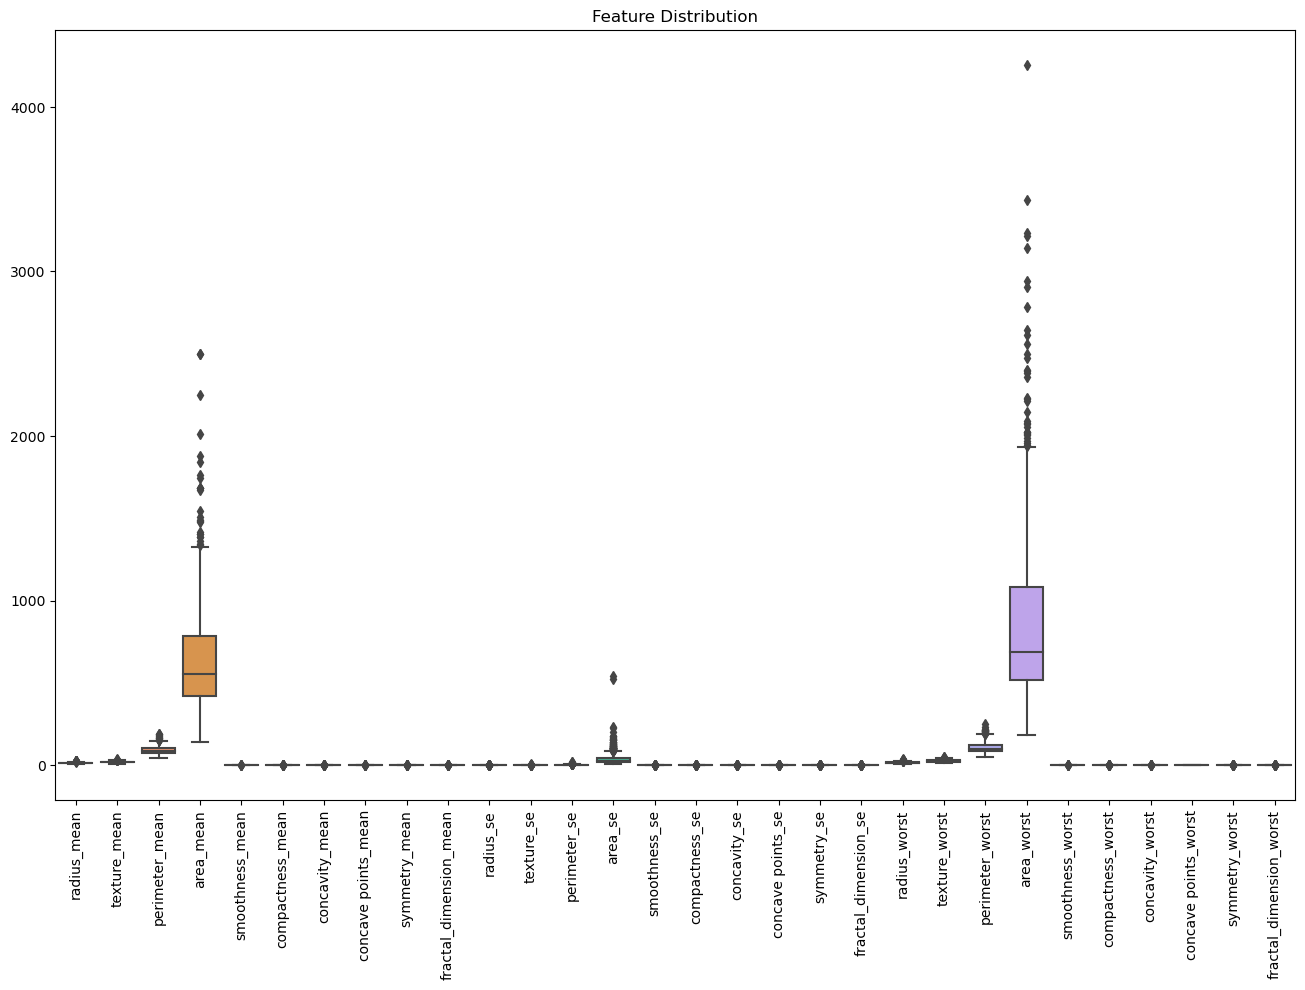

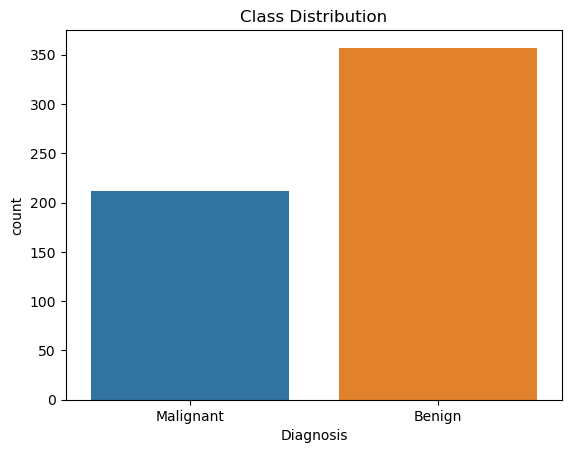

In [2]:
# Distribution of the features
feature_data = data.drop('diagnosis', axis=1)
plt.figure(figsize=(16, 10))
sns.boxplot(data=feature_data)
plt.xticks(rotation=90)
plt.title('Feature Distribution')
plt.show()

# Class distribution
sns.countplot(data=data, x='diagnosis')
plt.title('Class Distribution')
plt.xlabel('Diagnosis')
plt.xticks(ticks=[0, 1], labels=['Malignant', 'Benign'])
plt.show()


# ***Define the neural network then train it***

In [3]:
# Define the neural network architecture
class CancerNet(nn.Module):
    def __init__(self):
        super(CancerNet, self).__init__()
        self.fc1 = nn.Linear(30, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate and train the neural network
model = CancerNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []  # Store losses for each epoch

num_epochs = 11
for epoch in range(num_epochs):
    running_loss = 0.0
    i = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        i += 1
        
    epoch_loss = running_loss / (i + 1)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
# Generate predictions for the entire dataset (to be used for training the decision tree)
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
with torch.no_grad():
    model_outputs = model(features_tensor)
    _, model_predictions = torch.max(model_outputs.data, 1)

Epoch [1/11], Loss: 0.6058
Epoch [2/11], Loss: 0.5095
Epoch [3/11], Loss: 0.4111
Epoch [4/11], Loss: 0.3037
Epoch [5/11], Loss: 0.2358
Epoch [6/11], Loss: 0.1785
Epoch [7/11], Loss: 0.1367
Epoch [8/11], Loss: 0.1196
Epoch [9/11], Loss: 0.0914
Epoch [10/11], Loss: 0.0804
Epoch [11/11], Loss: 0.0735


# ***Plot the training loss***

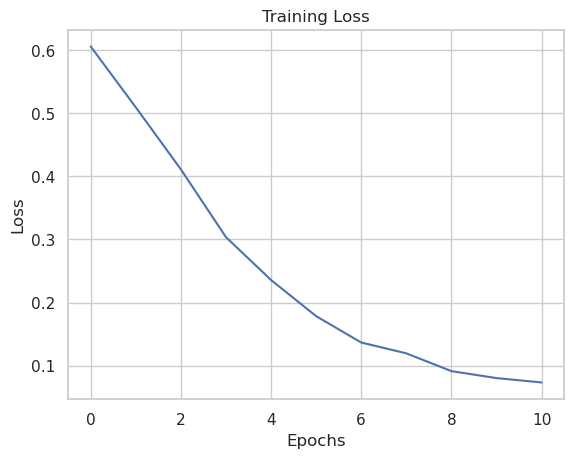

In [4]:
sns.set(style="whitegrid")
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# ***Calculate the neural netwrok's accuracy on unseen data***

In [5]:
# Function to calculate accuracy
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return 100 * correct / total

# Test the neural network
model.eval()
test_accuracy_nn = calculate_accuracy(test_loader, model)
print(f'Test accuracy: {test_accuracy_nn:.2f}%')

Test accuracy: 98.25%


# ***Create, train and test the decision tree***

In [6]:
# Train a decision tree using the neural network's predictions as target values
UDt = DecisionTreeClassifier()
UDt.fit(features_scaled, model_predictions.numpy())

# Predict the test data using the trained decision tree
train_preds = UDt.predict(train_features)
test_preds = UDt.predict(test_features)

# Calculate the accuracy score of the predictions

train_accuracy_unoptimized = accuracy_score(train_labels, train_preds)
test_accuracy_unoptimized = accuracy_score(test_labels, test_preds)

# Calculate the number of branches for the best individual
n_leaf_nodes = UDt.tree_.n_leaves
n_branches = n_leaf_nodes - 1

print(f"Max tree depth: {UDt.tree_.max_depth}")
print(f"Number of branches: {n_branches}")
print(f"Train accuracy: {train_accuracy_unoptimized * 100:.2f}%, Test accuracy: {test_accuracy_unoptimized * 100:.2f}%")

Max tree depth: 5
Number of branches: 16
Train accuracy: 97.80%, Test accuracy: 98.25%


# ***Plot the confusion matrix for the unoptimized decision tree***

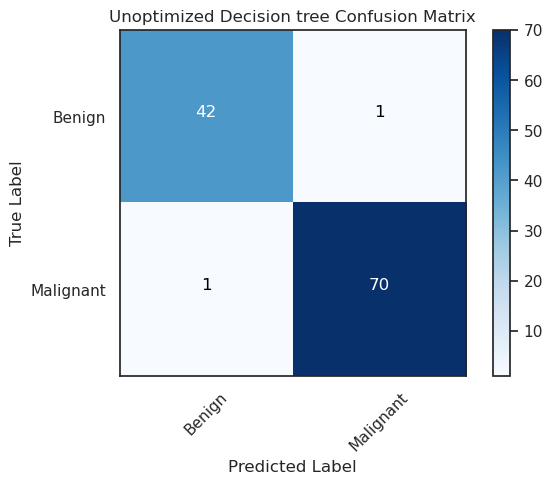

In [7]:

# Calculate the confusion matrix
test_predictions_unoptimized = UDt.predict(test_features)
cm_unoptimized = confusion_matrix(test_labels, test_predictions_unoptimized)
sns.set(style="white")
# Plot the confusion matrix
plt.figure()
plt.imshow(cm_unoptimized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Unoptimized Decision tree Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malignant'])

import itertools
for i, j in itertools.product(range(cm_unoptimized.shape[0]), range(cm_unoptimized.shape[1])):
    plt.text(j, i, cm_unoptimized[i, j], horizontalalignment="center", color="white" if cm_unoptimized[i, j] > cm_unoptimized.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ***Change variables for genetic algorithm here:***

In [8]:
threshold = 0.9  # Set a threshold for minimum improvement
patience = 10  # Set a patience level to allow some generations without improvement
population = 200 # Set the number of individuals per generation
generations = 100 # Set the number of maximum generations

# ***Define the genetic algorithm***

In [9]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=train_features.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Calculate the fitness score based on max depth and number of branches
def fitness(individual, features, labels):
    mask = np.array(individual, dtype=bool)
    masked_features = features[:, mask]
    
    if masked_features.shape[1] == 0:
        return float('inf'),

    clf = DecisionTreeClassifier()
    clf.fit(masked_features, labels)
    
    score_depth = clf.tree_.max_depth
    n_leaf_nodes = clf.tree_.n_leaves  # This attribute gives the number of leaf nodes in the tree
    score_width = n_leaf_nodes - 1  # The total number of branches is the number of leaf nodes minus 1

    score = score_depth + score_width  # Combine depth and width scores    
    return score,

toolbox.register("evaluate", fitness, features=train_features, labels=train_labels)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=10)

population = toolbox.population(n=population) # Define number of individuals
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# ***Run the genetic algorithm and extract the best feature mask***
***Please note that the code contains early stopping so the genetic algorithm might not run for the full number of generations.***

***To deactivate the early stopping set the "patience" variable to the total number of generations, in the cell above.***

In [10]:
no_improv_counter = 0  # Initialize a counter for iterations without improvement
prev_best_fitness = None  # Initialize a variable to hold the best fitness from the previous iteration
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

# Run the genetic algorithm with early stopping
for gen in range(generations):  # Run for a maximum of n generations
    population = algorithms.varAnd(population, toolbox, cxpb=0.7, mutpb=0.4)  # Perform mating and mutation
    invalid_ind = [ind for ind in population if not ind.fitness.valid]  # Extract individuals with invalid fitness
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)  # Evaluate the individuals with an invalid fitness
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit  # Assign new fitness values to individuals

    # Update hall of fame and statistics
    hof.update(population)
    record = stats.compile(population)
    logbook.record(gen=gen, **record)

    # Print current generation and best fitness
    print("Generation: ", gen, ", Best Fitness: ", hof[0].fitness.values[0])

    # Check for improvement
    if prev_best_fitness is None or hof[0].fitness.values[0] < prev_best_fitness - threshold:
        no_improv_counter = 0  # Reset the counter
        prev_best_fitness = hof[0].fitness.values[0]  # Update the previous best fitness
    else:
        no_improv_counter += 1  # Increment the counter

    # Early stopping
    if no_improv_counter >= patience:
        print("Stopping early due to lack of improvement.")
        break

# Extract the best individual (feature mask)
best_individual = hof[0]

Generation:  0 , Best Fitness:  21.0
Generation:  1 , Best Fitness:  20.0
Generation:  2 , Best Fitness:  20.0
Generation:  3 , Best Fitness:  20.0
Generation:  4 , Best Fitness:  20.0
Generation:  5 , Best Fitness:  20.0
Generation:  6 , Best Fitness:  20.0
Generation:  7 , Best Fitness:  20.0
Generation:  8 , Best Fitness:  20.0
Generation:  9 , Best Fitness:  20.0
Generation:  10 , Best Fitness:  20.0
Generation:  11 , Best Fitness:  20.0
Stopping early due to lack of improvement.


# ***Plot the genetic algorithm fitness***

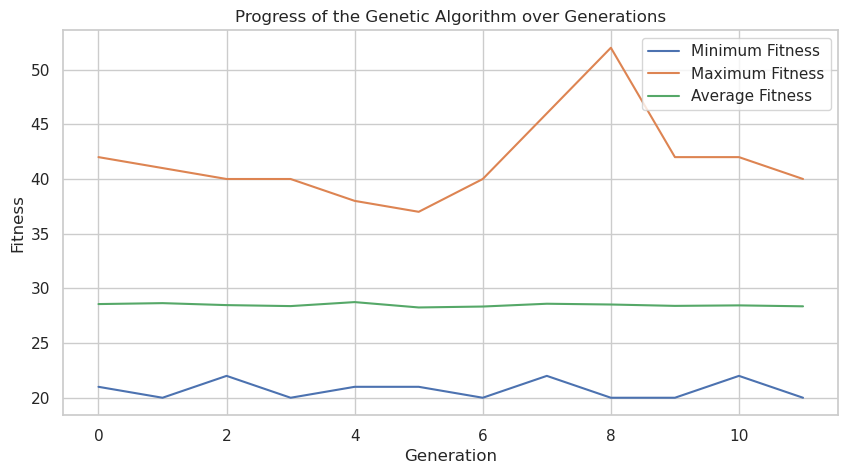

In [11]:
import matplotlib.pyplot as plt

# Extract data from the logbook
min_fitness_values = logbook.select('min')
max_fitness_values = logbook.select('max')
avg_fitness_values = logbook.select('avg')

# Plot the data
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
plt.plot(min_fitness_values, label='Minimum Fitness')
plt.plot(max_fitness_values, label='Maximum Fitness')
plt.plot(avg_fitness_values, label='Average Fitness')

# Customize the plot
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Progress of the Genetic Algorithm over Generations')
plt.legend(loc='upper right')

# Show the plot
plt.show()

# ***Create, train and test the optimized decision tree***

In [12]:
# Train and evaluate the decision tree with the best feature mask
mask = np.array(best_individual, dtype=bool)
ODt = DecisionTreeClassifier()
ODt.fit(train_features[:, mask], train_labels)
train_accuracy = (ODt.predict(train_features[:, mask]) == train_labels).mean()
test_accuracy = (ODt.predict(test_features[:, mask]) == test_labels).mean()

# Calculate the number of branches for the best individual
n_leaf_nodes = ODt.tree_.n_leaves
n_branches = n_leaf_nodes - 1

print(f"Best individual: {best_individual}")
print(f"Number of selected features: {sum(best_individual)}")
print(f"Max tree depth: {ODt.tree_.max_depth}")
print(f"Number of branches: {n_branches}")
print(f"Train accuracy: {train_accuracy * 100:.2f}%, Test accuracy: {test_accuracy * 100:.2f}%")


Best individual: [0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]
Number of selected features: 17
Max tree depth: 6
Number of branches: 14
Train accuracy: 100.00%, Test accuracy: 93.86%


# ***Plot the confusion matrix for the optimized decision tree***

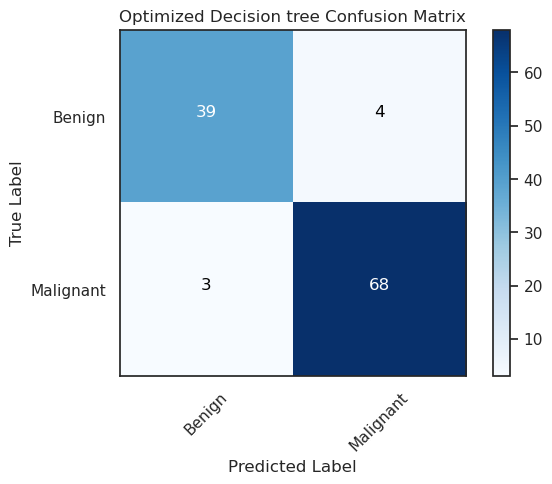

In [13]:
# Calculate the confusion matrix
test_predictions_unoptimized = ODt.predict(test_features[:, mask])
cm_unoptimized = confusion_matrix(test_labels, test_predictions_unoptimized)

# Plot the confusion matrix
sns.set(style="white")
plt.figure()
plt.imshow(cm_unoptimized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Optimized Decision tree Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Benign', 'Malignant'], rotation=45)
plt.yticks(tick_marks, ['Benign', 'Malignant'])

import itertools
for i, j in itertools.product(range(cm_unoptimized.shape[0]), range(cm_unoptimized.shape[1])):
    plt.text(j, i, cm_unoptimized[i, j], horizontalalignment="center", color="white" if cm_unoptimized[i, j] > cm_unoptimized.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# ***Plot a bar chart to compare the accuracy of the unoptimized decision tree and the optimized decision tree***

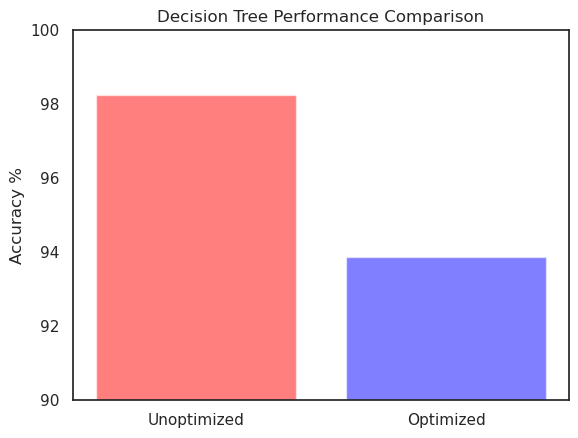

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
objects = ('Unoptimized', 'Optimized')
y_pos = np.arange(len(objects))
performance = [ test_accuracy_unoptimized * 100,  test_accuracy * 100]

# Create the bar chart
plt.figure()
plt.bar(y_pos, performance, align='center', alpha=0.5, color=['red', 'blue'])
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy %')
plt.title('Decision Tree Performance Comparison')
plt.ylim(90, 100)

# Show the bar chart
plt.show()

# ***Save the variables of the run to a csv file***

In [15]:
import csv


# Gather the data to save
details = [
    ("Batch Size", batch_size),
    ("Neural network Num epochs", num_epochs),
    ("Neural network Test Accuracy", f"{test_accuracy_nn * 100:.2f}%"),
    ("Number of Generations", generations),
    ("Population", population),
    ("Number of Selected Features", sum(best_individual)),
    ("Max Tree Depth", ODt.tree_.max_depth),
    ("Number of Branches", n_branches),
    ("GA OPT DT Train Accuracy", f"{train_accuracy * 100:.2f}%"),
    ("GA OPT DT Test Accuracy", f"{test_accuracy * 100:.2f}%"),
    ("Unoptimized Tree Max Depth", UDt.tree_.max_depth),
    ("Unoptimized Tree Number of Branches", UDt.tree_.n_leaves - 1),
    ("Unoptimized Tree Train Accuracy", f"{train_accuracy_unoptimized * 100:.2f}%"),
    ("Unoptimized Tree Test Accuracy", f"{test_accuracy_unoptimized * 100:.2f}%"),
]

# Save the data to a CSV file
with open("results.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(["Parameter", "Value"])
    for row in details:
        csv_writer.writerow(row)


# ***Save the plots of the decision trees and the decision trees with the classifiaction path for a row highlighted***
***Change which row by changing the "row" variable to the row number***

In [16]:
# Choose row to show example path

row = 5

def get_decision_path(clf, features):
    tree = clf.tree_
    node = 0
    decision_path = []

    while tree.children_left[node] != tree.children_right[node]:
        decision_path.append(node)
        if features[tree.feature[node]] <= tree.threshold[node]:
            node = tree.children_left[node]
        else:
            node = tree.children_right[node]
    
    decision_path.append(node)  # Add the leaf node to the path
    return decision_path

def visualize_tree(clf, feature_names, class_names, decision_path=None, filename=None):
    dot_data = export_graphviz(
        clf, out_file=None,
        feature_names=feature_names,
        class_names=class_names,
        filled=True, rounded=True,
        special_characters=True
    )
    
    graph = Digraph(filename=filename)
    tree = clf.tree_
    tree_nodes = tree.node_count
    decision_path = set() if decision_path is None else set(decision_path)

    # Build the decision tree graph
    for node in range(tree_nodes):
        if tree.children_left[node] != tree.children_right[node]:
            label = f'{feature_names[tree.feature[node]]} <= {tree.threshold[node]:.2f}'
            graph.node(str(node), label=label, shape='box', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')
            if tree.children_left[node] != -1:
                graph.edge(str(node), str(tree.children_left[node]), label='True', color='red' if tree.children_left[node] in decision_path else 'black', penwidth='3' if tree.children_left[node] in decision_path else '1')
            if tree.children_right[node] != -1:
                graph.edge(str(node), str(tree.children_right[node]), label='False', color='red' if tree.children_right[node] in decision_path else 'black', penwidth='3' if tree.children_right[node] in decision_path else '1')
        else:
            label = f'{class_names[np.argmax(tree.value[node])]}'
            graph.node(str(node), label=label, shape='ellipse', color='red' if node in decision_path else 'black', penwidth='3' if node in decision_path else '1')

    return graph

# Use one row of the Cancer dataset
cancer_row = features_scaled[row]  # or any other index

# Get the leaf node ID and decision path for the cancer row
node_id = ODt.tree_.apply(np.array([cancer_row], dtype=np.float32))[0]
decision_path = get_decision_path(ODt, cancer_row)

selected_feature_names = [name for name, mask in zip(data.columns[1:], best_individual) if mask]

# Visualize the optimised decision tree with the path highlighted
class_names = ['malignant', 'benign']
graph = visualize_tree(ODt, selected_feature_names, class_names, decision_path=decision_path, filename='Optimised_path')
graph.view()

# Visualize the optimised decision tree
graph = visualize_tree(ODt, selected_feature_names, class_names, filename='Optimised_tree')
graph.view()

# Visualize the unoptimised decision tree with the path highlighted
decision_path = get_decision_path(UDt, cancer_row)
feature_names = data.columns[1:]
graph = visualize_tree(UDt, feature_names, class_names, decision_path=decision_path, filename='Unoptimised_path')
graph.view()

# Visualize the unoptimised decision tree
graph = visualize_tree(UDt, feature_names, class_names, filename='Unoptimised_tree')
graph.view()

Error: no "view" mailcap rules found for type "application/pdf"
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Optimised_tree.pdf'
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'Optimised_path.pdf'
Error: no "view" mailcap rules found for type "application/pdf"
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin

'Unoptimised_tree.pdf'